# Simple Seldonian Algorithm Example

#### Author: Dasha Asienga

The purpose of this notebook is to work through the Seldonian algorithm tutorial and understand the computational aspects of the framework.

We will be running linear regression on simulated data.

** Fill in details from notes on the experiment :)

## Import Necessary Packages 

`math` provides access to the standard mathematical functions. 

`numpy` supports large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

`sys` provides functions and variables used to manipulate different parts of the Python runtime environment.

`sklearn` features various classification, regression and clustering algorithms.

`scipy.stats` contains a large number of probability distributions, summary and frequency statistics, correlation functions and statistical tests, masked statistics, kernel density estimation, quasi-Monte Carlo functionality, and more.

`scipy.optimize` provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints. It includes solvers for nonlinear problems (with support for both local and global optimization algorithms), linear programing, constrained and nonlinear least-squares, root finding, and curve fitting.

In [1]:
import math
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import t
from scipy.optimize import minimize # The black-box optimization algorithm used to find a candidate solution

Now, let's configure how floating-point numbers are displayed when printed to the console. `precision=5` will display 5 decimal places. `suppress=True` suppresses the use of scientific notation for very large or very small numbers. 

In [2]:
np.set_printoptions(precision=5, suppress=True)

## Implement Simple Functions
These functions are not specific to Seldonian algorithms, but they will be useful.

### tinv

This function returns the inverse of `Student's t` CDF using the degrees of freedom in `nu` for the corresponding probabilities in `p`. It is a Python implementation of Matlab's tinv function: https://www.mathworks.com/help/stats/tinv.html

In [3]:
def tinv(p, nu):
    return t.ppf(p, nu)

In [4]:
?t.ppf

Find the 95th percentile of the Student's t distribution with 50 degrees of freedom.

In [5]:
tinv(0.95,50)

1.6759050245283311

### stddev

This function computes the sample standard deviation of the vector v, with Bessel's correction. In statistics, Bessel's correction is the use of `n − 1` instead of `n` in the formula for the sample variance and sample standard deviation, where n is the number of observations in a sample. This method corrects the bias in the estimation of the population variance.

In [6]:
def stddev(v):
    n = v.size
    variance = (np.var(v) * n) / (n-1) # Variance with Bessel's correction
    return np.sqrt(variance)           # Compute the standard deviation

### ttestUpperBound

This function computes a (1-delta)-confidence upper bound on the expected value of a random variable using Student's t-test. It analyzes the data in v, which holds i.i.d. samples of the random variable. The upper confidence bound is given by `sampleMean + sampleStandardDeviation/sqrt(n) * tinv(1-delta, n-1)`, where n is the number of points in v.

In [7]:
def ttestUpperBound(v, delta):
    n  = v.size
    res = v.mean() + stddev(v) / math.sqrt(n) * tinv(1.0 - delta, n - 1)
    return res

### predictTTestUpperBound

This function works similarly to `ttestUpperBound`, but returns a more conservative upper bound. This is useful to make the Seldonian algorithm less confident that a given candidate solution is safe, thus making the generated candidate solutions more conservative. Such behavior helps when searching for candidate solutions that are likely to pass the safety test. This function uses data in the vector v to compute all relevant statistics (mean and standard deviation) but assumes that the number of points being analyzed is k instead of |v|.

This function is used to estimate what the output of ttestUpperBound would be if it were to be run on a new vector, v, containing values sampled from the same distribution as the points in v. The 2.0 factor in the calculation is used to double the width of the confidence interval when predicting the outcome of the safety test in order to make the algorithm less confident/ more conservative.

In [8]:
def predictTTestUpperBound(v, delta, k):
    # conservative prediction of what the upper bound will be in the safety test for the a given constraint
    res = v.mean() + 2.0 * stddev(v) / math.sqrt(k) * tinv(1.0 - delta, k - 1)
    return res

## Run a Simple Experiment

The function `main()` below is set up to run a simple experiment. Notice that it relies on some things that we will need to write:

- `generateData` will be a function that generates a data set for us to run the algorithm on.
- `gHat1` will be $ĝ_1$ and `gHat2` will be $ĝ_2$.
- `QSA` will be our quasi-Seldonian algorithm. The pair of objects returned by QSA is the solution (first element) and a Boolean flag indicating whether a solution that satisfies all behavioral constraints was found (second element).

In [9]:
def main():
    np.random.seed(0)  # Create the random number generator to use, with seed zero
    numPoints = 5000   # Let's use 5000 points

    (X,Y)  = generateData(numPoints)  # Generate the data

    # Create the behavioral constraints - each is a gHat function and a confidence level delta
    gHats  = [gHat1, gHat2] # The 1st gHat requires MSE < 2.0. The 2nd gHat requires MSE > 1.25
    deltas = [0.1, 0.1]

    (result, found) = QSA(X, Y, gHats, deltas) # Run the Quasi-Seldonian algorithm
    
    if found:
        print("A solution was found: [%.10f, %.10f]" % (result[0], result[1]))
        print("fHat of solution (computed over all data, D):", fHat(result, X, Y))
    else:
        print("No solution found")

## Problem Implementation

We now implement the regression problem that we defined earlier: https://aisafety.cs.umass.edu/tutorial2.html. 

### generateData

First, let's write the `generateData` function, which samples data as described in the problem description.

In [10]:
# Generate numPoints data points
def generateData(numPoints):
    X =     np.random.normal(0.0, 1.0, numPoints) # Sample x from a standard normal distribution
    Y = X + np.random.normal(0.0, 1.0, numPoints) # Set y to be x, plus noise from a standard normal distribution
    return (X,Y)

### predict

Now, let's write the function that takes in a solution $\theta$ and an input $X$, and produces as output the prediction of $Y$. In other words, this function will implement $\hat{y}(X, \theta)$.

Recall $\hat{y}(X, \theta) = \theta_1 X + \theta_2$.

In [11]:
# Uses the weights in theta to predict the output value, y, associated with the provided x.
# This function assumes we are performing linear regression, so that theta has two elements: 
# the y-intercept (first parameter) and slope (second parameter)
def predict(theta, x):
    return theta[0] + theta[1] * x

### fHat

Next, we write a function $\hat{f}$, which specifies our primary objective: to minimize the sample mean squared error. since we are attempting to maximize $\hat{f}$, however, we need to return the negative sample mean squared error, so that maximizing $\hat{f}$ corresponds to minimizing the mean squared error.

In [12]:
# Estimator of the primary objective, in this case, the negative sample mean squared error
def fHat(theta, X, Y):
    n = X.size          # Number of points in the data set
    res = 0.0           # Used to store the sample MSE we are computing
    for i in range(n):  # For each point X[i] in the data set ...
        prediction = predict(theta, X[i])                # Get the prediction using theta
        res += (prediction - Y[i]) * (prediction - Y[i]) # Add the squared error to the result
    res /= n            # Divide by the number of points to obtain the sample mean squared error
    return -res         # Returns the negative sample mean squared error

### gHat

Next, we write the functions $\hat{g}_1$ and $\hat{g}_2$ that will be provided as input to the Seldonian algorithm. 

Recall:
- $\hat{g}_{1,j}(\theta, D) = (\hat{y}(X_j, \theta) - Y_j)^2 - 2.0$
- $\hat{g}_{2,j}(\theta, D) = 1.25 - (\hat{y}(X_j, \theta) - Y_j)^2$

In [13]:
# Returns unbiased estimates of g_1(theta), computed using the provided data
def gHat1(theta, X, Y):
    n = X.size          # Number of points in the data set
    res = np.zeros(n)   # We will get one estimate per point; initialize res to store these estimates
    for i in range(n):
        prediction = predict(theta, X[i])                   # Compute the prediction for the i-th data point
        res[i] = (prediction - Y[i]) * (prediction - Y[i])  # Compute the squared error for the i-th data point
    res = res - 2.0     # We want the MSE to be less than 2.0, so g(theta) = MSE-2.0
    return res

# Returns unbiased estimates of g_2(theta), computed using the provided data
def gHat2(theta, X, Y):
    n = X.size          # Number of points in the data set
    res = np.zeros(n)   # We will get one estimate per point; initialize res to store these estimates
    for i in range(n):
        prediction = predict(theta, X[i])                   # Compute the prediction for the i-th data point
        res[i] = (prediction - Y[i]) * (prediction - Y[i])  # Compute the squared error for the i-th data point
    res = 1.25 - res    # We want the MSE to be at least 1.25, so g(theta) = 1.25-MSE
    return res

### Ordinary Least Squares (OLS) Regression

Later in this tutorial we will want the ordinary least-squares solution to be used as a starting point during the search for a candidate solution. The following code implements least squares linear regression:

In [14]:
# Run ordinary least squares linear regression on data (X,Y)
def leastSq(X, Y):
    X = np.expand_dims(X, axis=1) # Places the input  data in a matrix
    Y = np.expand_dims(Y, axis=1) # Places the output data in a matrix
    reg = LinearRegression().fit(X, Y)
    theta0 = reg.intercept_[0]   # Gets theta0, the y-intercept coefficient
    theta1 = reg.coef_[0][0]     # Gets theta0, the slope coefficient
    return np.array([theta0, theta1])

We now have all of the libraries that we need and all of the functions to implement the problem that we specified earlier. Now we're ready to start writing our Seldonian algorithm! From here it's easy—by line-count, we've already written most of the code.

## Safety Test

Before we implement the safety test, let us write a shell for our quasi-Seldonian algorithm, which we will call QSA. This shell code will show how the safety test will be used. At a high level, we are simply partitioning the data, getting a candidate solution, and running the safety test.

Notice also that we are placing 40% of the data in candidateData and 60% in safetyData. This train/ test split is an arbitrary choice and it remains an open question.

In [15]:
# Our Quasi-Seldonian linear regression algorithm operating over data (X,Y).
# The pair of objects returned by QSA is the solution (first element) 
# and a Boolean flag indicating whether a solution was found (second element).
def QSA(X, Y, gHats, deltas):
  # Put 40% of the data in candidateData (D1), and the rest in safetyData (D2)
    candidateData_len = 0.40
    candidateData_X, safetyData_X, candidateData_Y, safetyData_Y = train_test_split(
      X, Y, test_size=1-candidateData_len, shuffle=False)
  
  # Get the candidate solution
    candidateSolution = getCandidateSolution(candidateData_X, candidateData_Y, gHats, deltas, safetyData_X.size)

  # Run the safety test
    passedSafety      = safetyTest(candidateSolution, safetyData_X, safetyData_Y, gHats, deltas)

  # Return the result and success flag
    return [candidateSolution, passedSafety]

Now, let's write the function for the safety test using the helper functions we already have.

Recall the pseudocode for the safety test:

Return $\theta_c$ if $$\forall i \in \{1,2,3,...,n\}, \hat{\mu}(\hat{g_i}(\theta_c, D_2)) + \frac{\hat{\sigma}(\hat{g_i}(\theta_c, D_2))}{\sqrt{|D_2|}} t_{1-\delta_i, |D_2|-1} \leq 0,$$ and No Solution Found (NSF) otherwise.

In [16]:
# Run the safety test on a candidate solution. Returns true if the test is passed.
#   candidateSolution: the solution to test. 
#   (safetyData_X, safetyData_Y): data set D2 to be used in the safety test.
#   (gHats, deltas): vectors containing the behavioral constraints and confidence levels.
def safetyTest(candidateSolution, safetyData_X, safetyData_Y, gHats, deltas):

    for i in range(len(gHats)):  # Loop over behavioral constraints, checking each
        g         = gHats[i]  # The current behavioral constraint being checked
        delta     = deltas[i] # The confidence level of the constraint

    # This is a vector of unbiased estimates of g(candidateSolution) -- defined above
        g_samples = g(candidateSolution, safetyData_X, safetyData_Y) 

    # Check if the i-th behavioral constraint is satisfied
        upperBound = ttestUpperBound(g_samples, delta) 

        if upperBound > 0.0: # If the current constraint was not satisfied, the safety test failed
            return False

  # If we get here, all of the behavioral constraints were satisfied      
    return True

We're almost there. All that's left is the the function `getCandidateSolution`!

## Candidate Selection

Recall the pseudocode for computing the candidate solution:

Use a black-box optimization algorithm to compute $\theta_c$ that approximates a solution to $$\theta_c \in arg \: \underset{\theta \in \Theta}{max} \hat{f}(\theta, D_1)$$ $$s.t. \forall i \in \{1,2,3,...,n\}, \hat{\mu}(\hat{g_i}(\theta_c, D_1)) + 2 \frac{\hat{\sigma}(\hat{g_i}(\theta_c, D_1))}{\sqrt{|D_2|}} t_{1-\delta_i, |D_2|-1} \leq 0.$$

The black box algorithm used to search for a candidate solution is called Powell, which is simply an algorithm designed for finding a local minimum of a function using a bi-directional linear search. Powell, however, is not a constrained algorithm. One way of addressing this limitation is by incorporating the constraint into the objective function as a barrier function. In constrained optimization, a field of mathematics, barrier functions are used to replace inequality constraints by a penalizing term in the objective function that is easier to handle. 

That is, we will now find an approximate solution to the following unconstrained problem:

$$\theta_c \in arg \: \underset{\theta \in \mathbb{R}^2}{max} 
    \begin{cases} 
      \hat{f}(\theta, D_1) &  \text{if} \:\: \hat{\mu}(\hat{g_i}(\theta_c, D_1)) + 2 \frac{\hat{\sigma}(\hat{g_i}(\theta_c, D_1))}{\sqrt{|D_2|}} t_{1-\delta_i, |D_2|-1} \leq 0 \\
      -100,000 - \sum_{i=1}^n max(0, \hat{f}(\theta, D_1)  \text{if} \:\: \hat{\mu}(\hat{g_i}(\theta_c, D_1)) + 2 \frac{\hat{\sigma}(\hat{g_i}(\theta_c, D_1))}{\sqrt{|D_2|}} t_{1-\delta_i, |D_2|-1})) & \text{otherwise}
    \end{cases}
$$

In this case, solutions that are predicted not to pass the safety test will not be selected by the optimization algorithm because we assign a large negative performance to them. This barrier functions encourages Powell to tend towards solutions that will pass the safety test. 

Let us now write the objective function that Powell will attempt to maximize.

In [17]:
# The objective function maximized by getCandidateSolution.
#     thetaToEvaluate: the candidate solution to evaluate.
#     (candidateData_X, candidateData_Y): the data set D1 used to evaluated the solution.
#     (gHats, deltas): vectors containing the behavioral constraints and confidence levels.
#     safetyDataSize: |D2|, used when computing the conservative upper bound on each behavioral constraint.
def candidateObjective(thetaToEvaluate, candidateData_X, candidateData_Y, gHats, deltas, safetyDataSize): 

  # Get the primary objective of the solution, fHat(thetaToEvaluate)
    result = fHat(thetaToEvaluate, candidateData_X, candidateData_Y)

    predictSafetyTest = True     # Prediction of what the safety test will return. Initialized to "True" = pass
    
    for i in range(len(gHats)):  # Loop over behavioral constraints, checking each
        g         = gHats[i]       # The current behavioral constraint being checked
        delta     = deltas[i]      # The confidence level of the constraint

    # This is a vector of unbiased estimates of g_i(thetaToEvaluate)
        g_samples = g(thetaToEvaluate, candidateData_X, candidateData_Y)

    # Get the conservative prediction of what the upper bound on g_i(thetaToEvaluate) will be in the safety test
        upperBound = predictTTestUpperBound(g_samples, delta, safetyDataSize)

    # We don't think the i-th constraint will pass the safety test if we return this candidate solution
        if upperBound > 0.0:

            if predictSafetyTest:
        # Set this flag to indicate that we don't think the safety test will pass
                predictSafetyTest = False  
    
        # Put a barrier in the objective. Any solution that we think will fail the safety test will have a
        # large negative performance associated with it
                result = -100000.0    

      # Add a shaping to the objective function that will push the search toward solutions that will pass 
      # the prediction of the safety test
            result = result - upperBound

  # Negative because our optimizer (Powell) is a minimizer, but we want to maximize the candidate objective
    return -result  

Now that we have our candidate objective function, we can write `getCandidateSolution`, which uses Powell to search for a solution that maximizes `candidateObjective`.

In [18]:
# Use the provided data to get a candidate solution expected to pass the safety test.
#    (candidateData_X, candidateData_Y): data used to compute a candidate solution.
#    (gHats, deltas): vectors containing the behavioral constraints and confidence levels.
#    safetyDataSize: |D2|, used when computing the conservative upper bound on each behavioral constraint.
def getCandidateSolution(candidateData_X, candidateData_Y, gHats, deltas, safetyDataSize):
  
  # Chooses the black-box optimizer we will use (Powell)
    minimizer_method = 'Powell'
    minimizer_options={'disp': False}

  # Initial solution given to Powell: simple linear fit we'd get from ordinary least squares linear regression
    initialSolution = leastSq(candidateData_X, candidateData_Y)

  # Use Powell to get a candidate solution that tries to maximize candidateObjective
    res = minimize(candidateObjective, x0=initialSolution, method=minimizer_method, options=minimizer_options, 
    args=(candidateData_X, candidateData_Y, gHats, deltas, safetyDataSize))

  # Return the candidate solution we believe will pass the safety test
    return res.x

In [19]:
?minimize

## Find a Solution

In [20]:
main()

A solution was found: [0.5844721756, 1.0560192943]
fHat of solution (computed over all data, D): -1.3494829214565587


In other words, our Quasi-Seldonian algorithm found a solution that minimizes the sample mean squared error, while ensuring (with high probability) that all behavioral constraints are satisfied!

That solution was $\hat{Y} = 0.5844721756 + 1.0560192943X$ with an MSE of $1.3494829214565587$, which is indeed between 1.25 and 2.

## Plotting

In [21]:
X, Y = generateData(5000)

In [26]:
X

array([-0.32298, -0.65385,  1.77588, ..., -0.32127, -1.0682 ,  0.59271])

In [27]:
Y

array([-0.04999, -0.18147,  2.02476, ..., -0.24941, -1.29424,  1.89743])

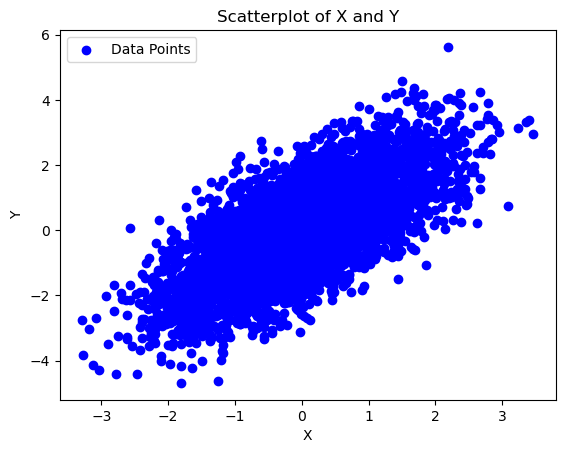

In [31]:
import matplotlib.pyplot as plt 

# Create a scatterplot
plt.scatter(X, Y, c='b', marker='o', label='Data Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of X and Y')
plt.legend()
plt.grid(True)

# Eliminate grid lines
plt.grid(False)

# Display the plot
plt.show()

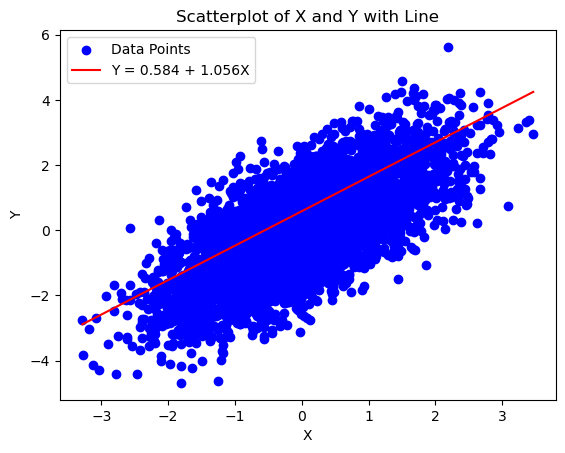

In [33]:
# Define the line equation
a = 0.5844721756
b = 1.0560192943

# Generate X values for the line
line_X = np.linspace(min(X), max(X), 5000)

# Calculate Y values based on the line equation
line_Y = a + b * line_X

# Create a scatterplot
plt.scatter(X, Y, c='b', marker='o', label='Data Points')
plt.plot(line_X, line_Y, c='r', label='Y = 0.584 + 1.056X')  # Add the line
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of X and Y with Line')
plt.legend()

# Eliminate grid lines
plt.grid(False)

# Display the plot
plt.show()

In [32]:
?np.linspace

In [35]:
c, d = leastSq(X, Y)

In [36]:
c

0.0186415121122152

In [37]:
d

1.0007598212882112

The ordinary least squares solution, on the other hand, was $\hat{Y} = 0.0186415121122152 + 1.0007598212882112$.

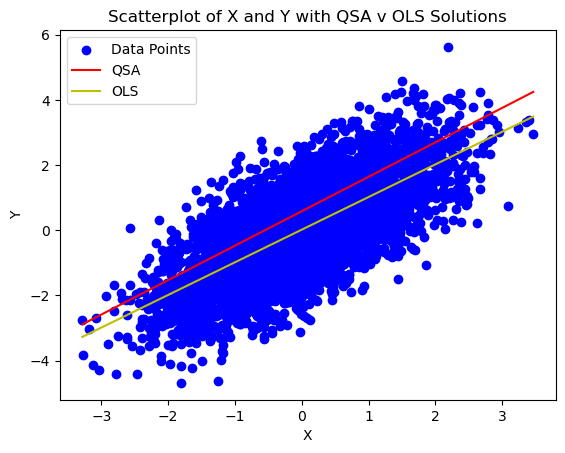

In [40]:
# Generate X values for the line
line_X2 = np.linspace(min(X), max(X), 5000)

# Calculate Y values based on the line equation
line_Y2 = c + d * line_X2

# Create a scatterplot
plt.scatter(X, Y, c='b', marker='o', label='Data Points')
plt.plot(line_X, line_Y, c='r', label='QSA')  # Add the line
plt.plot(line_X2, line_Y2, c='y', label='OLS')  # Add the line
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of X and Y with QSA v OLS Solutions')
plt.legend()

# Eliminate grid lines
plt.grid(False)

# Display the plot
plt.show()

# Next Steps

The next tutorial will go through how we can change the code in main() to repeatedly run our Quasi-Seldonian algorithm QSA using different amounts of data and printing results to files that can be used to create plots like Fig. 3 in the original Seldonian paper. This will allow us to analyze:

- How much performance (mean square error minimization) is lost due to the behavioral constraints?
- How much data does it take for the algorithm to frequently return solutions?
- How often does the algorithm exhibit undesirable behavior?

## Import Additional Packages

`timeit` allows us to time the execution of our experiments.

`ray` allows us to execute experiments in parallel. 

`number` allows us to use `jit`, which is a Just-in-Time (JIT) compiler to accelerate Python code.

Note that the pip install statements below should not be run twice. 

In [21]:
#!pip install ray

In [22]:
#pip install -U ipywidgets

In [23]:
import timeit               
import ray                  
ray.init()    
from numba import jit       

2023-10-11 21:08:31,703	INFO worker.py:1642 -- Started a local Ray instance.


## Run Multiple Experiments

Let's first create a folder where the experiment results will be saved.

In [24]:
bin_path = 'experiment_results_dasha/bin/'

Now, let's set up the experiments.

We want to investigate performance loss, probability of a solution, and probability of undesired behavior.

A few things to note:

1. The `.npz` file type is a file format used in NumPy, a popular library for numerical and scientific computing in Python. It is primarily used for saving and loading multiple NumPy arrays into a single compressed archive file. The `.npz` format is a way to store multiple arrays in a single file, which can be useful for data storage and sharing in scientific and data analysis applications. It's commonly used in scientific research and data analysis workflows to save and load experimental data, model parameters, or any other numerical data that needs to be preserved in a structured and efficient manner.

2. `np.savez()` is a function in the NumPy library for Python that is used to save multiple NumPy arrays into a single compressed archive file with the `.npz` extension. 

3. We will have `numTrials` trials for each value of `ms` data set size. That is, in trial 1, we will generate training data sets of size ms and run QSA. Then, we will move on to trial 2 and do the same. At the end, we will have multiple trials for each data set size we are interested in. We will keep the random seed consistent within a trial but different between different trials. 

4. We will keep the test set constant across the entire experiment. 

In [35]:
@ray.remote
def run_experiments(worker_id, nWorkers, ms, numM, numTrials, mTest):
    
    # Results of the Seldonian algorithm runs
    ## The following code initializes an array filled with 0's. The resulting array will have numTrials rows (each trial) and numM columns (each data set size). Default is 0=False.
    
    seldonian_solutions_found = np.zeros((numTrials, numM)) # Stores whether a solution was found (1=True,0=False)
    seldonian_failures_g1     = np.zeros((numTrials, numM)) # Stores whether solution was unsafe, (1=True,0=False), for the 1st constraint, g_1
    seldonian_failures_g2     = np.zeros((numTrials, numM)) # Stores whether solution was unsafe, (1=True,0=False), for the 2nd constraint, g_2
    seldonian_fs              = np.zeros((numTrials, numM)) # Stores the primary objective values (fHat) if a solution was found
    
    # Results of the Least-Squares (LS) linear regression runs
    LS_solutions_found = np.ones((numTrials, numM))  # Stores whether a solution was found. These will all be true (=1)
    LS_failures_g1     = np.zeros((numTrials, numM)) # Stores whether solution was unsafe, (1=True,0=False), for the 1st constraint, g_1
    LS_failures_g2     = np.zeros((numTrials, numM)) # Stores whether solution was unsafe, (1=True,0=False), for the 2nd constraint, g_2
    LS_fs              = np.zeros((numTrials, numM)) # Stores the primary objective values (f) if a solution was found
    
    
    # Prepares file where experiment results will be saved
    experiment_number = worker_id
    outputFile = bin_path + 'results%d.npz' % experiment_number
    print("Writing output to", outputFile)
    
    
    # Generate the data used to evaluate the primary objective and failure rates
    np.random.seed( (experiment_number+1) * 9999 )
    (testX, testY) = generateData(mTest) #we defined this above & mTest is the number of points in the test set 
    
    
    for trial in range(numTrials): #numTrials trials for each value of m 
        for (mIndex, m) in enumerate(ms): #different amounts of data to evaluate in each trial
            # Generate the training data, D
            base_seed         = (experiment_number * numTrials)+1
            np.random.seed(base_seed+trial) # done to obtain common random numbers for all values of m (all data set sizes) in the same trial but different numbers for different trials
            (trainX, trainY)  = generateData(m)
            
            # Run the Quasi-Seldonian algorithm
            (result, passedSafetyTest) = QSA(trainX, trainY, gHats, deltas)
            
            if passedSafetyTest:
                seldonian_solutions_found[trial, mIndex] = 1                        # A solution was found 
                trueMSE = -fHat(result, testX, testY)                               # Get the "true" mean squared error using the testData
                seldonian_failures_g1[trial, mIndex] = 1 if trueMSE > 2.0  else 0   # Check if the first behavioral constraint was violated
                seldonian_failures_g2[trial, mIndex] = 1 if trueMSE < 1.25 else 0   # Check if the second behavioral constraint was violated
                seldonian_fs[trial, mIndex] = -trueMSE                              # Store the "true" negative mean-squared error (goal of maximizing)
                print(f"[(worker {worker_id}/{nWorkers}) Seldonian trial {trial+1}/{numTrials}, m {m}] A solution was found: [{result[0]:.10f}, {result[1]:.10f}]\tfHat over test data: {trueMSE:.10f}")
            else:
                seldonian_solutions_found[trial, mIndex] = 0             # A solution was not found
                seldonian_failures_g1[trial, mIndex]     = 0             # Returning NSF means the first constraint was not violated
                seldonian_failures_g2[trial, mIndex]     = 0             # Returning NSF means the second constraint was not violated
                seldonian_fs[trial, mIndex]              = None          # This value should not be used later. We use None and later remove the None values
                print(f"[(worker {worker_id}/{nWorkers}) Seldonian trial {trial+1}/{numTrials}, m {m}] No solution found")

            # Run the Least Squares algorithm
            theta = leastSq(trainX, trainY)                              # Run least squares linear regression
            trueMSE = -fHat(theta, testX, testY)                         # Get the "true" mean squared error using the testData
            LS_failures_g1[trial, mIndex] = 1 if trueMSE > 2.0  else 0   # Check if the first behavioral constraint was violated
            LS_failures_g2[trial, mIndex] = 1 if trueMSE < 1.25 else 0   # Check if the second behavioral constraint was violated
            LS_fs[trial, mIndex] = -trueMSE                              # Store the "true" negative mean-squared error
            print(f"[(worker {worker_id}/{nWorkers}) LeastSq trial {trial+1}/{numTrials}, m {m}] LS fHat over test data: {trueMSE:.10f}")
            
        print()
        
        
    # Save the arrays in a compressed format
    np.savez(outputFile, 
             ms=ms, 
             seldonian_solutions_found=seldonian_solutions_found,
             seldonian_fs=seldonian_fs, 
             seldonian_failures_g1=seldonian_failures_g1, 
             seldonian_failures_g2=seldonian_failures_g2,
             LS_solutions_found=LS_solutions_found,
             LS_fs=LS_fs,
             LS_failures_g1=LS_failures_g1,
             LS_failures_g2=LS_failures_g2)

Finally, let's run the experiments.

In parallel computing or multithreading applications, setting the number of workers or threads can have a significant impact on performance, as it determines how many tasks can be executed simultaneously, , assuming there are enough computing resources available to support this level of parallelism. This can potentially lead to faster execution of experiments or computations.

In a logarithmic scale, values are not linearly spaced but instead increase or decrease by a constant multiplicative factor, typically represented as a power of some base value. We will use a base value of 2. 

In [36]:
# Create the behavioral constraints: each is a gHat function and a confidence level delta
gHats  = [gHat1, gHat2]
deltas = [0.1, 0.1]

nWorkers = 16                # Workers is the number of threads running experiments in parallel
print(f"Running experiments on {nWorkers} threads") 

# We will use different amounts of data, m. The different values of m will be stored in ms.
# These values correspond to the horizontal axis locations in all three plots we will make.
# We will use a logarithmic horizontal axis, so the amounts of data we use shouldn't be evenly spaced.
ms   = [2**i for i in range(5, 17)]  # ms = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
numM = len(ms)
    
# How many trials should we average over?
#numTrials = 70 # We pick 70 because with 70 trials per worker, and 16 workers, we get >1000 trials for each value of m
numTrials = 5

# How much data should we generate to compute the estimates of the primary objective and behavioral constraint function values 
# that we call "ground truth"? Each candidate solution deemed safe, and identified using limited training data, will be evaluated 
# over this large number of points to check whether it is really safe, and to compute its "true" mean squared error.
mTest = ms[-1] * 100 # about 5,000,000 test samples

# Start 'nWorkers' threads in parallel, each one running 'numTrials' trials. Each thread saves its results to a file
tic = timeit.default_timer()
_ = ray.get([run_experiments.remote(worker_id, nWorkers, ms, numM, numTrials, mTest) for worker_id in range(1,nWorkers+1)])
toc = timeit.default_timer()
time_parallel = toc - tic # Elapsed time in seconds
print(f"Time ellapsed: {time_parallel}")

Running experiments on 16 threads
(run_experiments pid=7517) [(worker 1/16) LeastSq trial 5/70, m 65536] LS fHat over test data: 0.9995542631
(run_experiments pid=7517) 
(run_experiments pid=7517) [(worker 1/16) Seldonian trial 6/70, m 32] No solution found
(run_experiments pid=7516) [(worker 2/16) Seldonian trial 5/70, m 65536] A solution was found: [0.5431828326, 0.9985814431]	fHat over test data: 1.2946872851


KeyboardInterrupt: 